In [18]:
import re
import unicodedata
from collections import Counter
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency, ttest_ind
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from prince import MCA
import string
from collections import Counter

In [19]:
df = pd.read_excel(r"C:\Users\LuChunyi\Desktop\Study\LSE\Dissertation\CDRC\Non-UK national rough sleeping census_origin.xlsx")

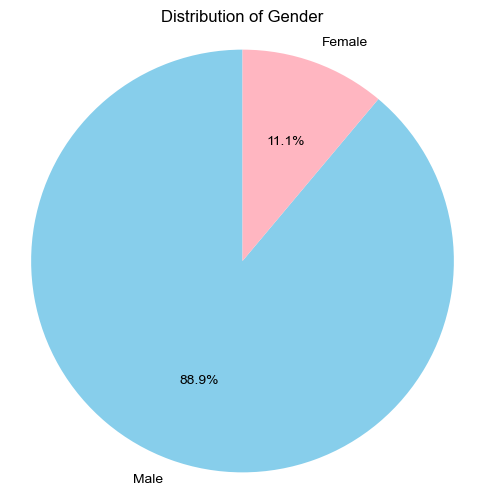

In [20]:
# Gender Distribution
df['gender'] = df['What is your gender?'].str.strip()

gender_counts = df['gender'].value_counts()

plt.figure(figsize=(6,6))
plt.pie(
    gender_counts,
    labels=gender_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=['skyblue', 'lightpink']
)
plt.title('Distribution of Gender')
plt.axis('equal')  
plt.show()

In [21]:
n = 36          
x = 32         
p0 = 0.82       

test_stat, p_value = sm.stats.proportions_ztest(count=x, nobs=n, value=p0)

print("Z-statistic:", test_stat)
print("p-value:", p_value)

Z-statistic: 1.3152186130069783
p-value: 0.18843644141544236


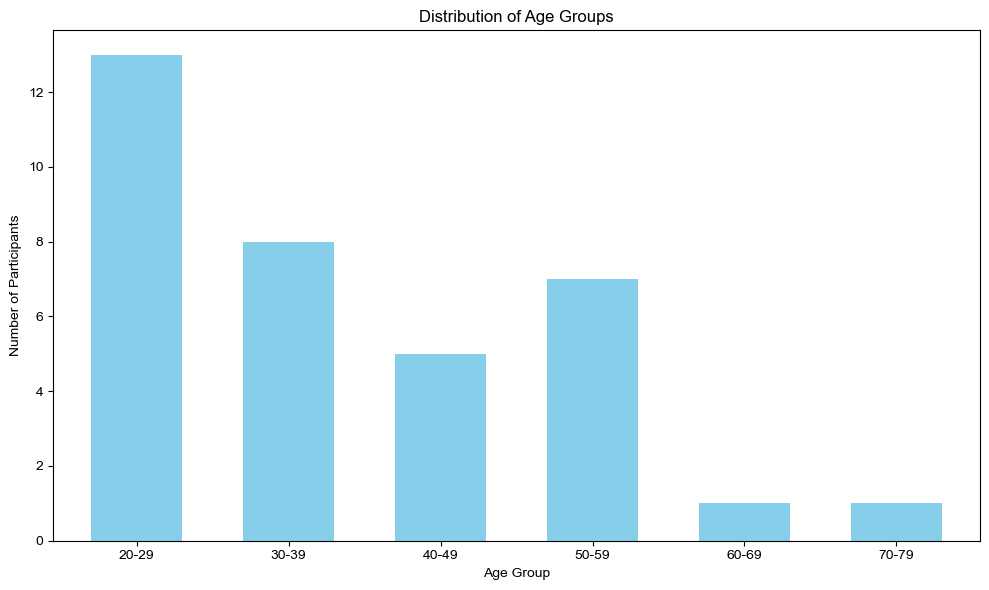

In [22]:
# Age Distribution
df['age'] = pd.to_numeric(df['How old are you?'], errors='coerce')

bins = [20, 29, 39, 49, 59, 69, 79] 
labels = ['20-29', '30-39', '40-49', '50-59', '60-69', '70-79']

df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, right=True, include_lowest=True)

age_counts = df['age_group'].value_counts().sort_index()

plt.figure(figsize=(10,6))
age_counts.plot(kind='bar', color='skyblue', width=0.6)
plt.xlabel('Age Group')
plt.ylabel('Number of Participants')
plt.title('Distribution of Age Groups')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

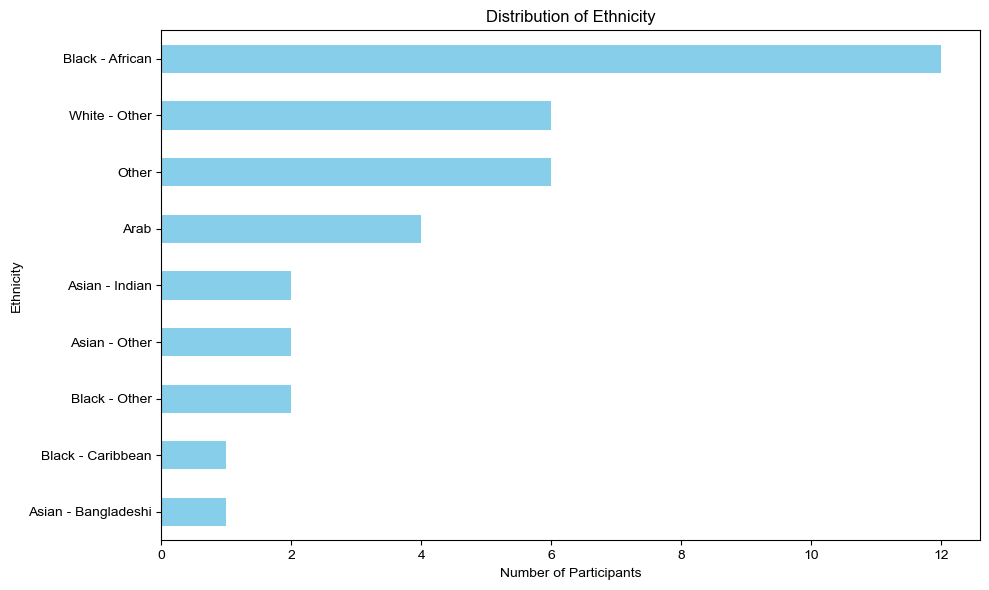

In [23]:
# Ethnicity Distribution
df['ethnicity'] = df['How would you describe your ethnicity? '].str.strip()
df['nationality'] = df['What best describes your nationality?'].str.strip()

eth_counts_sorted = df['ethnicity'].value_counts().sort_values()

plt.figure(figsize=(10,6))
eth_counts_sorted.plot(kind='barh', color='skyblue')
plt.xlabel('Number of Participants')
plt.ylabel('Ethnicity')
plt.title('Distribution of Ethnicity')
plt.tight_layout()
plt.show()

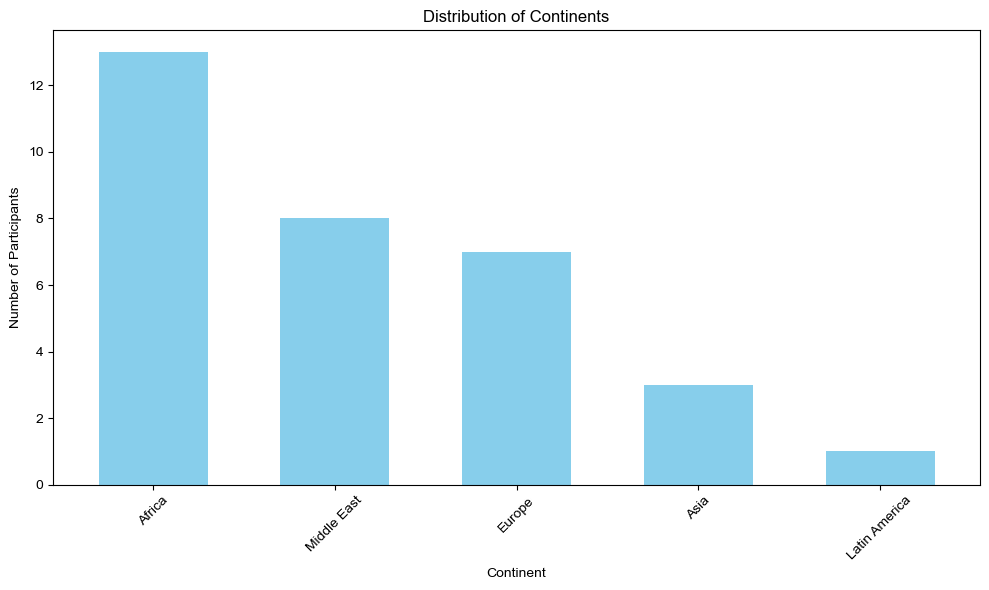

In [24]:
# Nationality Distribution
continent_map = {
    'Iraq': 'Middle East', 'Yemen': 'Middle East', 'Oman': 'Middle East', 'Iranian national': 'Middle East',
    'Sudanese': 'Africa', 'SUDAN': 'Africa', 'Eritherian': 'Africa', 'Eritrean': 'Africa',
    'Ethiopian': 'Africa', 'Ugandan': 'Africa', 'Nigerian': 'Africa', 'Namibian': 'Africa', 'Somalia': 'Africa', 'Angola': 'Africa', 'Zimbabwean': 'Africa',
    'Bangladish': 'Asia', 'Indian': 'Asia', 'Syrian': 'Middle East',
    'Lithuanian': 'Europe', 'Romanian': 'Europe', 'Polish': 'Europe', 'Slovakia': 'Europe', 'European': 'Europe', 'Kurdish': 'Middle East',
    'Brazilian': 'Latin America'
}

df['continent'] = df['nationality'].map(continent_map)

continent_counts = df['continent'].value_counts()

plt.figure(figsize=(10,6))
continent_counts.plot(kind='bar', color='skyblue', width=0.6)
plt.xlabel('Continent')
plt.ylabel('Number of Participants')
plt.title('Distribution of Continents')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

What is your current immigration status? 
No Immigration Status (undocumented/ overstayer)     25.0
Refugee                                              19.4
Other Limited Leave to Remain                        16.7
Asylum Seeker                                        11.1
Refused Asylum Seeker                                 8.3
EU/ EEA Pre Settled Status or Settled Status          8.3
Indefinite Leave to Remain                            5.6
Don't know                                            5.6
Name: proportion, dtype: float64


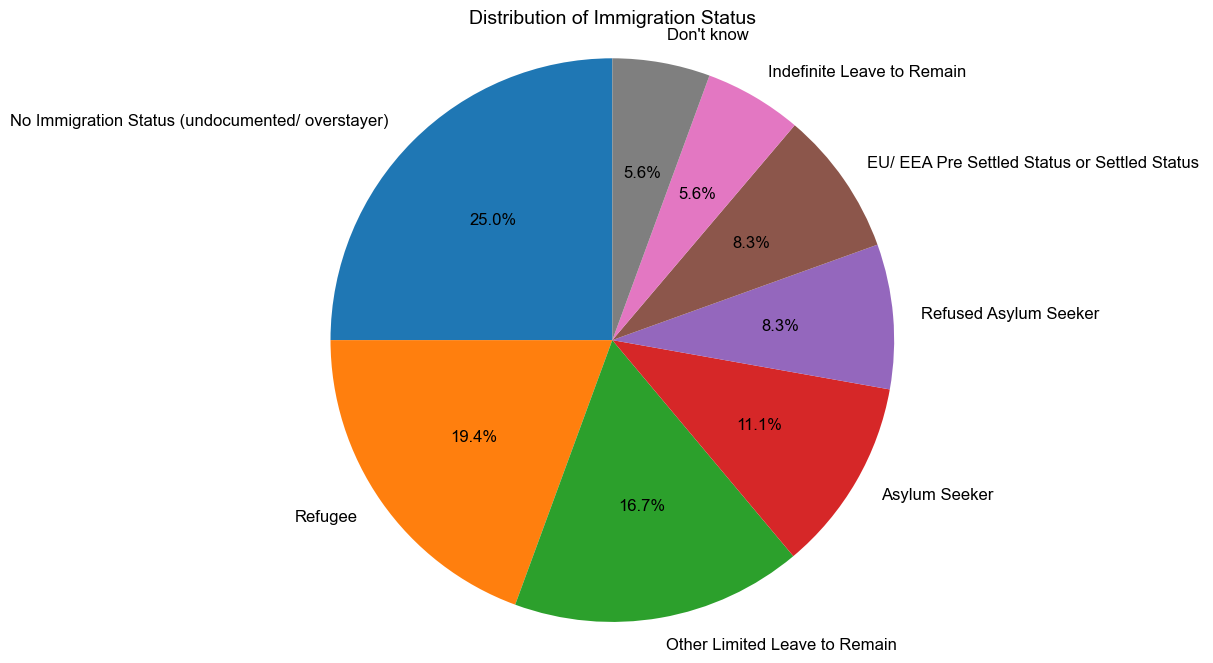

In [25]:
# Immigration Status Distribution
df['immigration_status'] = (
    df['What is your current immigration status? ']
    .astype(str)
    .str.strip()
    .str.replace(r'[\u200f\u200e\u00a0\u200b\t\n\r]', '', regex=True)
    .str.replace(r'\s+', ' ', regex=True)
)

status_dist = df['What is your current immigration status? '].value_counts(normalize=True).mul(100).round(1)

print(status_dist)

plt.figure(figsize=(8,8))
plt.pie(status_dist, labels=status_dist.index, autopct='%1.1f%%', startangle=90, textprops={'fontsize':12})
plt.title('Distribution of Immigration Status', fontsize=14)
plt.axis('equal')  
plt.show()

Contingency Table:
 long_term_rough                                   False  True 
immigration_status                                            
Asylum Seeker                                         2      2
Don't know                                            0      2
EU/ EEA Pre Settled Status or Settled Status          2      1
Indefinite Leave to Remain                            2      0
No Immigration Status (undocumented/ overstayer)      0      9
Other Limited Leave to Remain                         3      3
Refugee                                               4      3
Refused Asylum Seeker                                 0      3

Chi-square test result: chi2 = 14.84, p-value = 0.0381, dof = 7
Long-term rough sleeping percentage by immigration status:

immigration_status
Don't know                                          100.0
No Immigration Status (undocumented/ overstayer)    100.0
Refused Asylum Seeker                               100.0
Asylum Seeker                   

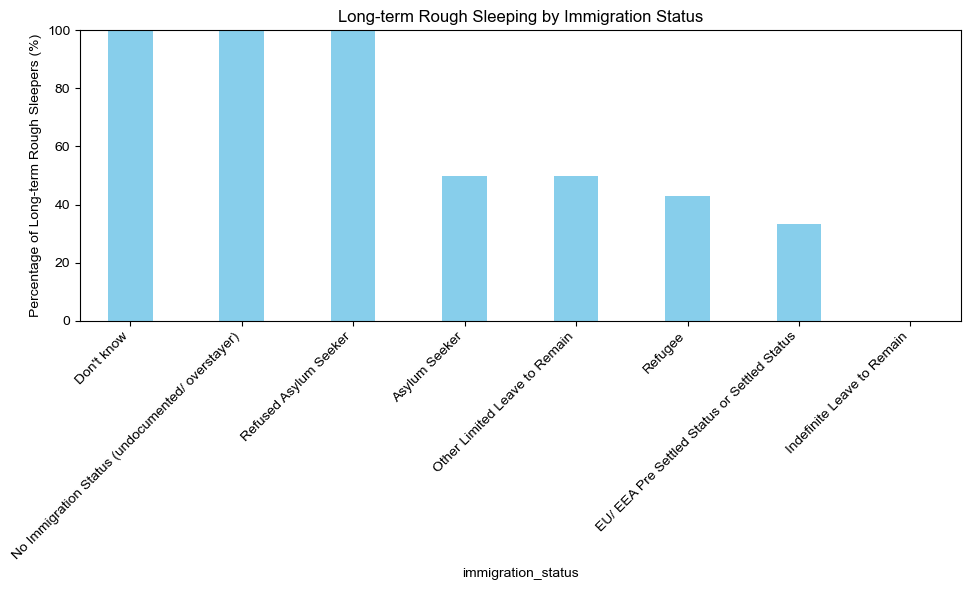

In [26]:
# Nights of Rough Sleeping
df['nights_rough'] = pd.to_numeric(
    df["Approximately how many nights have you 'slept rough' in total in the last 3 months? "],
    errors='coerce'
)

def parse_nights(x):
    if pd.isna(x):
        return None
    x = str(x).strip()
    if x == "Every night":
        return 90   
    elif x == "60+ nights":
        return 60  
    elif x == "31-60 nights":
        return 45
    elif x == "21-30 nights":
        return 25
    elif x == "11-20 nights":
        return 15
    elif x == "6-10 nights":
        return 8
    elif x == "2-5 nights":
        return 3
    elif x == "1 night":
        return 1
    elif x.lower().startswith("unsure"):
        return None
    else:
        return None

df["nights_num"] = df["Approximately how many nights have you 'slept rough' in total in the last 3 months? "].apply(parse_nights)

df['long_term_rough'] = df['nights_num'] > 30

contingency_table = pd.crosstab(
    df['immigration_status'],
    df['long_term_rough']
)

print("Contingency Table:\n", contingency_table)

chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"\nChi-square test result: chi2 = {chi2:.2f}, p-value = {p:.4f}, dof = {dof}")

percent_table = (
    df.groupby('immigration_status')['long_term_rough']
      .mean()  
      .mul(100) 
      .round(1)
      .sort_values(ascending=False)
)

print("Long-term rough sleeping percentage by immigration status:\n")
print(percent_table)

plt.figure(figsize=(10,6))

plt.rcParams['font.family'] = 'Arial'
percent_table.plot(kind='bar', color='skyblue', width=0.4)
plt.ylabel('Percentage of Long-term Rough Sleepers (%)')
plt.title('Long-term Rough Sleeping by Immigration Status')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

In [27]:
# NRPF Status
nrpf_col = 'Does your immigration status include No Recourse to Public Funds (NRPF)? No Recourse to Public Funds is a condition of certain visas in the UK, meaning you cannot access most benefits and financial su'
df[nrpf_col] = df[nrpf_col].astype(str).str.strip().str.replace(r'[\u200f\u200e\u00a0\u200b\t\n\r]', '', regex=True)


def map_nrpf(x):
    x_clean = x.strip().lower()
    if 'yes my immigration status includes no recourse to public funds' in x_clean:
        return 'NRPF_Yes'
    elif 'no my immigration status does not include no recourse to public funds' in x_clean:
        return 'NRPF_No'
    elif 'i have no immigration status' in x_clean:
        return 'No_Status'
    else:
        return 'Unknown'

df['NRPF_group'] = df[nrpf_col].apply(map_nrpf)

def parse_nights(x):
    if pd.isna(x):
        return None
    x = str(x).strip()
    if x == "Every night":
        return 90
    elif x == "60+ nights":
        return 60
    elif x == "31-60 nights":
        return 45
    elif x == "21-30 nights":
        return 25
    elif x == "11-20 nights":
        return 15
    elif x == "6-10 nights":
        return 8
    elif x == "2-5 nights":
        return 3
    elif x == "1 night":
        return 1
    elif x.lower().startswith("unsure"):
        return None
    else:
        return None

df['nights_num'] = df["Approximately how many nights have you 'slept rough' in total in the last 3 months? "].apply(parse_nights)

print(df['NRPF_group'].value_counts())

summary = df.groupby('NRPF_group').agg(
    count=('NRPF_group', 'size'),
    avg_nights=('nights_num', 'mean')
).reset_index()

print("\nSummary by NRPF group:")
print(summary)

nights_nrpf_yes = df[df['NRPF_group']=='NRPF_Yes']['nights_num'].dropna()
nights_nrpf_no = df[df['NRPF_group']=='NRPF_No']['nights_num'].dropna()
nights_no_status = df[df['NRPF_group']=='No_Status']['nights_num'].dropna()


t_stat, p_value = ttest_ind(nights_nrpf_yes, nights_nrpf_no, equal_var=False)
print(f"\nT-test (NRPF_Yes vs NRPF_No): t = {t_stat:.2f}, p = {p_value:.4f}")



NRPF_group
NRPF_Yes     15
NRPF_No      13
No_Status     8
Name: count, dtype: int64

Summary by NRPF group:
  NRPF_group  count  avg_nights
0    NRPF_No     13   19.750000
1   NRPF_Yes     15   68.428571
2  No_Status      8   65.625000

T-test (NRPF_Yes vs NRPF_No): t = 4.91, p = 0.0001


Prevalence of each sleeping location (%):
Slept outside on the street (including in a tent or make-shift shelter)    50.0
B&B/ Hotel/ Temporary Accommodation                                        47.2
At a bus or train station                                                  27.8
In a squat                                                                 25.0
Sofa surfing with a stranger                                               22.2
Other                                                                      22.2
Homelessness service e.g. hostel/ supported housing                        19.4
A&E waiting room                                                           16.7
Slept rough - other                                                        16.7
Walked around all night                                                    13.9
On a bus or train                                                          13.9
House - owned/ rented or social rented                                     13.

C:\Users\LuChunyi\AppData\Local\Temp\ipykernel_28160\2881428243.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


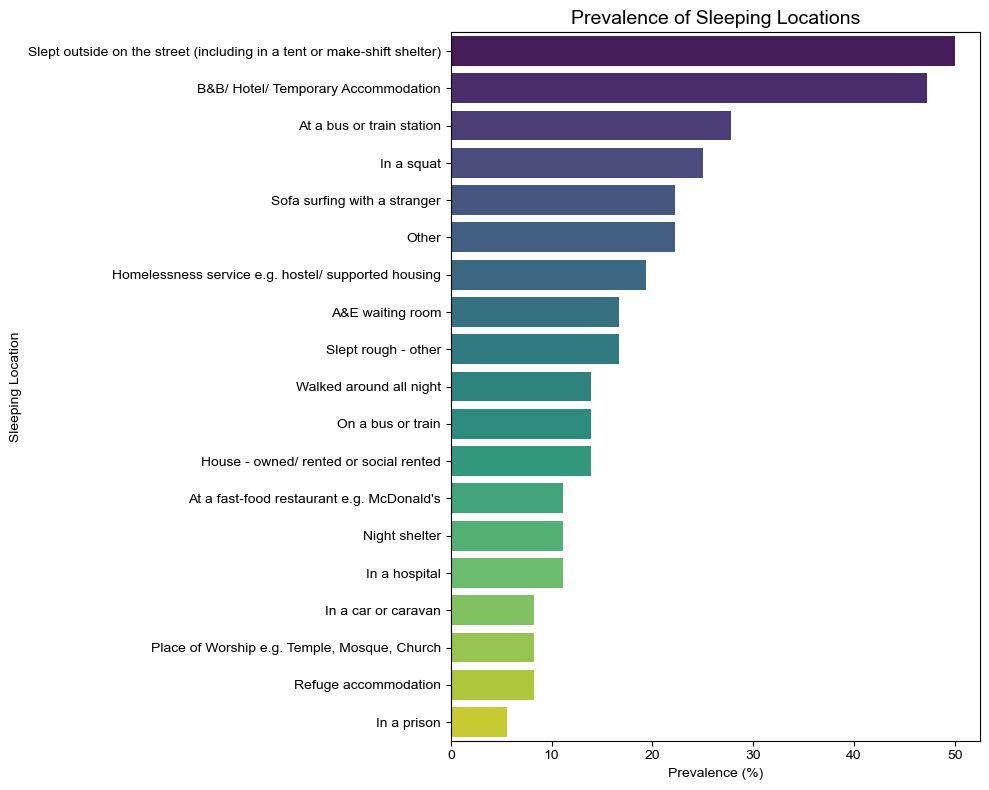

In [28]:
# Rough Sleeping Locations
location_columns = df.iloc[:, 5:24]

location_experience = location_columns.notna().astype(int)

location_experience.columns = (
    location_experience.columns
    .str.replace(u"\xa0", " ", regex=True) 
    .str.strip() 
    .str.replace(r"Where and for how long have you slept in the last 3 months\?\s*\.", "", regex=True)  
    .str.strip() 
)

location_prevalence = (location_experience.sum() / len(df)) * 100
location_prevalence = location_prevalence.round(1).sort_values(ascending=False)

print("Prevalence of each sleeping location (%):")
print(location_prevalence)

plt.figure(figsize=(10, 8))
sns.barplot(
    x=location_prevalence.values, 
    y=location_prevalence.index, 
    palette="viridis"
)

plt.title('Prevalence of Sleeping Locations', fontsize=14)
plt.xlabel('Prevalence (%)')
plt.ylabel('Sleeping Location')
plt.tight_layout()
plt.show()

Support summary:
                   Support Received  Support Desired
Accommodation                    3             14.0
Other                           36             14.0
Job/ Employment                  2              1.0
Legal Support                    5              1.0
Community/ Other                36              0.0
Food                            23              0.0
Health                          10              0.0
Refugee/ Asylum                 11              0.0


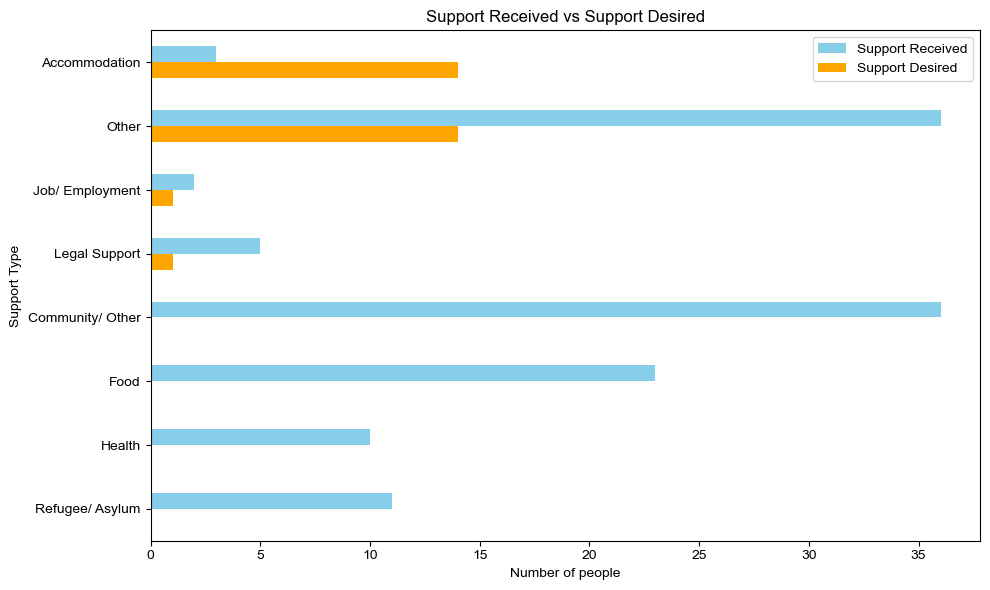

In [29]:
# Support Received vs Desired
support_mapping = {
    'Accommodation': ['Housing association', 'Housing officer or council housing department', 'Accommodation', 'Hostel', 'Night shelter'],
    'Food': ['Food bank', 'Soup kitchen', 'Meals service'],
    'Legal Support': ['Legal/ immigration advice (OISC)', 'Legal support', 'Immigration support'],
    'Job/ Employment': ['Job Centre', 'Support with looking for work', 'Help with permanent employment'],
    'Health': ['Health service', 'Drug or alcohol support service', 'Mental health support'],
    'Refugee/ Asylum': ['Refugee/ asylum support', 'Refugee accommodation'],
    'Community/ Other': ['Friends/ family', "Women's centre/ service", 'Religious or faith group e.g. Mosque, Church or Temple', 'Other', 'Homelessness organisation']
}

def standardize_support(item):
    item = str(item).strip()
    for key, variants in support_mapping.items():
        for v in variants:
            if v.lower() in item.lower():
                return key
    return 'Other'

all_support_received_std = []
for row in df['If you do receive support, where do you get support from?'].dropna():
    for s in str(row).split(';'):
        s_std = standardize_support(s)
        all_support_received_std.append(s_std)

all_support_desired_std = []
for row in df['If you would like to receive more support, what type of support would you like to receive?'].dropna():
    for s in str(row).split(';'):
        s_std = standardize_support(s)
        all_support_desired_std.append(s_std)

support_received_counts = Counter(all_support_received_std)

support_desired_counts = Counter(all_support_desired_std)

support_df = pd.DataFrame({
    'Support Received': pd.Series(support_received_counts),
    'Support Desired': pd.Series(support_desired_counts)
}).fillna(0)

support_df = support_df.sort_values('Support Desired', ascending=False)

print("Support summary:\n", support_df)

support_df.plot(kind='barh', figsize=(10,6), color=['skyblue','orange'])
plt.xlabel("Number of people")
plt.ylabel("Support Type")
plt.title("Support Received vs Support Desired")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


[('health', 12), ('work', 9), ('sleeping', 7), ('people', 5), ('difficult', 5), ('rough', 5), ('physical', 5), ('mental', 5), ('due', 5), ('want', 5), ('very', 4), ('there', 4), ('been', 4), ('out', 4), ('homeless', 4)]


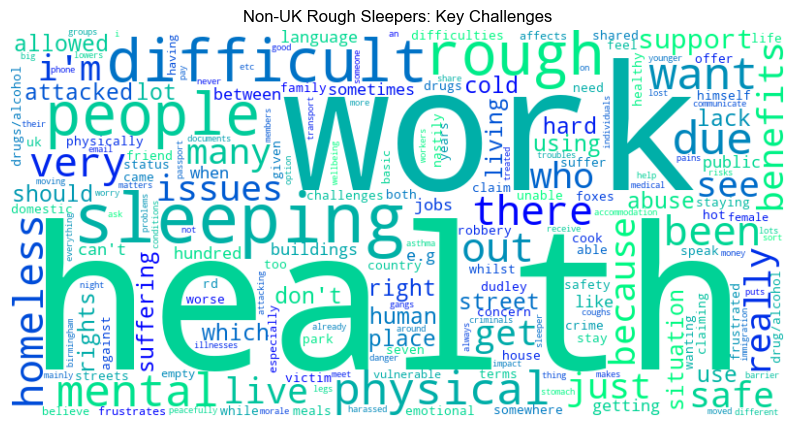

In [30]:
# Open-end Question Analysis
all_text = ' '.join(df["Are there any additional challenges you have experienced whilst 'sleeping rough' that you would like to share with us? e.g. mental health, victim of a crime, abuse etc."].fillna('').astype(str) + ' ' +
                    df['Is there anything else you would like to tell us? '].fillna('').astype(str))

all_text = all_text.lower()

words = all_text.split()

stop_words = set([
    'the', 'and', 'a', 'to', 'of', 'in', 'for', 'with', 'on', 'is', 'at', 
    'i', 'you', 'it', 'as', 'be', 'this', 'that', 'have', 'has', 'was', 'are',
    'my', 'me', 'so', 'but', 'if', 'or', 'not', 'they', 'we', 'our', 'all', 'any',
    'from', 'by', 'about', 'can', 'am', 'do', 'does', 'did', 'no', 'being'
])

filtered_words = [w.strip(string.punctuation) for w in words if w.strip(string.punctuation) and w not in stop_words]

word_freq = Counter(filtered_words)

print(word_freq.most_common(15))

wordcloud = WordCloud(width=800, height=400, background_color='white', colormap="winter").generate_from_frequencies(word_freq)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Non-UK Rough Sleepers: Key Challenges')
plt.show()


Trying to obtain explained variance ratio:
Using eigenvalues_ attribute
Explained inertia per dimension:
Dimension 1: 0.5580
Dimension 2: 0.4420
Row coordinates shape: (36, 2)
Column coordinates shape: (23, 2)


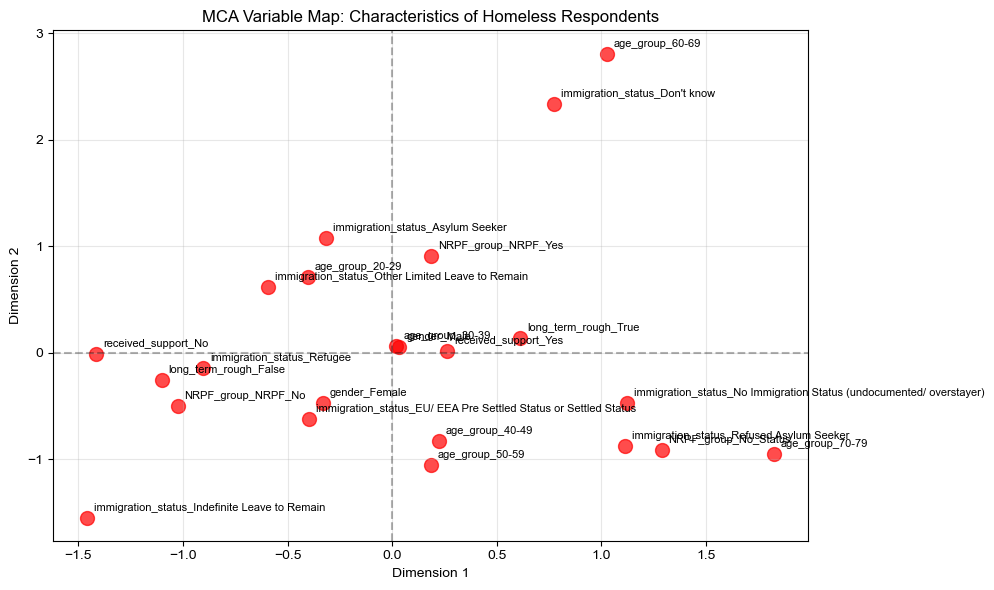

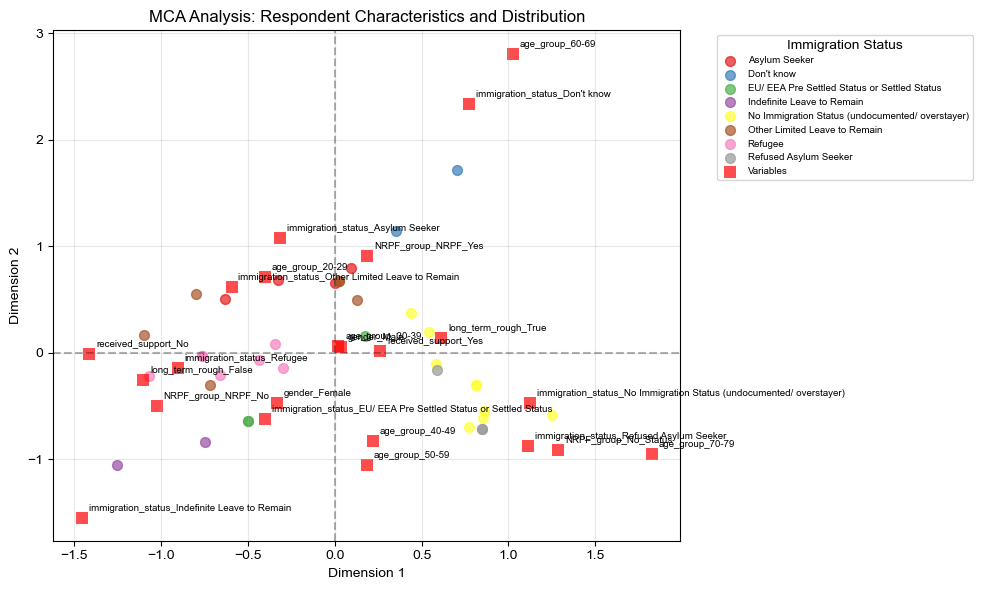


Variables contributing most to each dimension:

Dimension 1:
Top positive contributions:
  age_group_70-79: 1.825
  NRPF_group_No_Status: 1.288
  immigration_status_No Immigration Status (undocumented/ overstayer): 1.123
Top negative contributions:
  immigration_status_Indefinite Leave to Remain: -1.456
  received_support_No: -1.413
  long_term_rough_False: -1.101

Dimension 2:
Top positive contributions:
  age_group_60-69: 2.810
  immigration_status_Don't know: 2.340
  immigration_status_Asylum Seeker: 1.081
Top negative contributions:
  immigration_status_Indefinite Leave to Remain: -1.548
  age_group_50-59: -1.052
  age_group_70-79: -0.954


In [31]:
# Support Received vs Desired
df['received_support'] = df['Do you receive any support?'].map({'Yes': 'Yes', 'No': 'No'})

mca_df = df[[
    'immigration_status', 
    'NRPF_group',          
    'long_term_rough',     
    'gender',              
    'age_group',          
    'received_support'   
]].copy()

mca_df = mca_df.astype('category')

mca = MCA(n_components=2, random_state=42)
mca = mca.fit(mca_df)

print("\nTrying to obtain explained variance ratio:")
if hasattr(mca, 'explained_inertia_'):
    explained_inertia = mca.explained_inertia_
    print("Using explained_inertia_ attribute")
elif hasattr(mca, 'eigenvalues_'):
    eigenvalues = mca.eigenvalues_
    explained_inertia = eigenvalues / eigenvalues.sum()
    print("Using eigenvalues_ attribute")
elif hasattr(mca, 'total_inertia_') and hasattr(mca, 'eigenvalues_'):
    explained_inertia = mca.eigenvalues_ / mca.total_inertia_
    print("Using eigenvalues_ / total_inertia_ calculation")
else:
    try:
        transformed_data = mca.transform(mca_df)
        variances = np.var(transformed_data, axis=0)
        explained_inertia = variances / variances.sum()
        print("Manually calculated variance ratio")
    except:
        explained_inertia = None
        print("Unable to calculate explained variance ratio")

if explained_inertia is not None:
    print("Explained inertia per dimension:")
    for i, inertia in enumerate(explained_inertia[:2]):  
        print(f"Dimension {i + 1}: {inertia:.4f}")

row_coords = mca.transform(mca_df)

if hasattr(row_coords, 'values'):
    row_coords = row_coords.values
row_coords = np.array(row_coords)
print(f"Row coordinates shape: {row_coords.shape}")

col_coords = None
if hasattr(mca, 'column_coordinates_'):
    col_coords = mca.column_coordinates_
elif hasattr(mca, 'col_coords_'):
    col_coords = mca.col_coords_
else:
    try:
        col_coords = mca.column_coordinates(mca_df)
    except:
        print("Unable to get column coordinates, will only plot individual points")

if col_coords is not None:
    if hasattr(col_coords, 'values'):
        col_coords = col_coords.values
    col_coords = np.array(col_coords)
    print(f"Column coordinates shape: {col_coords.shape}")
else:
    print("Column coordinates are None")

# First plot: Variable map
plt.figure(figsize=(10, 6))
if col_coords is not None and col_coords.shape[1] >= 2:
    plt.scatter(col_coords[:, 0], col_coords[:, 1], s=100, alpha=0.7, c='red')
    
    categories = []
    for col in mca_df.columns:
        for cat in mca_df[col].cat.categories:
            categories.append(f"{col}_{cat}")
    
    if len(categories) == len(col_coords):
        for i, label in enumerate(categories):
            plt.annotate(label, (col_coords[i, 0], col_coords[i, 1]), 
                        xytext=(5, 5), textcoords='offset points', fontsize=8)
    else:
        print(f"Number of categories ({len(categories)}) does not match number of coordinates ({len(col_coords)})")
    
    plt.axhline(y=0, color='k', linestyle='--', alpha=0.3)
    plt.axvline(x=0, color='k', linestyle='--', alpha=0.3)
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.title('MCA Variable Map: Characteristics of Homeless Respondents')
    plt.grid(True, alpha=0.3)
else:
    plt.text(0.5, 0.5, 'Variable coordinates not available or insufficient dimensions', 
             ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('Variable Coordinates Not Available')

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))

# Plot individual points
if 'immigration_status' in mca_df.columns:
    unique_status = mca_df['immigration_status'].cat.categories
    colors = plt.cm.Set1(np.linspace(0, 1, len(unique_status)))
    color_dict = dict(zip(unique_status, colors))
    
    for status in unique_status:
        mask = mca_df['immigration_status'] == status
        mask_array = mask.values  
        plt.scatter(row_coords[mask_array, 0], row_coords[mask_array, 1], 
                   alpha=0.7, label=status, color=color_dict[status], s=50)
else:
    plt.scatter(row_coords[:, 0], row_coords[:, 1], alpha=0.7, s=50)

# Plot variable points
if col_coords is not None and col_coords.shape[1] >= 2:
    plt.scatter(col_coords[:, 0], col_coords[:, 1], s=80, alpha=0.7, 
               c='red', marker='s', linewidth=0, label='Variables') 
    
    if 'categories' in locals() and len(categories) == len(col_coords):
        for i, label in enumerate(categories):
            plt.annotate(label, (col_coords[i, 0], col_coords[i, 1]), 
                        xytext=(5, 5), textcoords='offset points', 
                        fontsize=7)

# Axes labels and title
plt.axhline(y=0, color='k', linestyle='--', alpha=0.3)
plt.axvline(x=0, color='k', linestyle='--', alpha=0.3)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('MCA Analysis: Respondent Characteristics and Distribution')

# Legend outside with smaller font
plt.legend(title='Immigration Status', bbox_to_anchor=(1.05, 1), loc='upper left', prop={'size': 7})

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

if col_coords is not None and col_coords.shape[1] >= 2 and 'categories' in locals() and len(categories) == len(col_coords):
    print("\nVariables contributing most to each dimension:")
    for dim in range(2):
        print(f"\nDimension {dim + 1}:")
        
        sorted_indices = np.argsort(np.abs(col_coords[:, dim]))[::-1]
        
        print("Top positive contributions:")
        pos_sorted = np.argsort(col_coords[:, dim])[::-1]
        for i in range(min(3, len(pos_sorted))):
            idx = pos_sorted[i]
            if col_coords[idx, dim] > 0:
                print(f"  {categories[idx]}: {col_coords[idx, dim]:.3f}")
        
        print("Top negative contributions:")
        neg_sorted = np.argsort(col_coords[:, dim])
        for i in range(min(3, len(neg_sorted))):
            idx = neg_sorted[i]
            if col_coords[idx, dim] < 0:
                print(f"  {categories[idx]}: {col_coords[idx, dim]:.3f}")
else:
    print("\nUnable to display variable contribution information")


